In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

#### Wang et al. Occupancy Model


In [ ]:
def wang_occ_model(rand_state=42, C1=0.5, C2=0.3, timestep=10, csv_name='office_occupancy_schedule.csv'):
    """
    based on Wang et al.'s office occupancy model
    (Wang, D., C. C. Federspiel, and F. Rubinstein. 2005. “Modeling Occupancy in Single Person Offices.” Energy and Buildings 37 (2): 121-126)
    C1: # vacation coefficient 1 between 0 and 1
    C2: # vacation coefficient 2 between 0 and 1
    timestep: time step in minutes, e.g., 10 for 10-minute intervals
    csv_name: name of the output CSV file
    """
    # draw random numbers from a normal distribution
    np.random.seed(rand_state)
    hours = np.arange(0, 24, timestep/60)  # 10-min timestep
    days = pd.date_range("2025-01-01", "2025-12-31", freq="D") # any non-leap year

    # Create dataframe
    records = []

    for day in days:
        
        day_of_week = day.weekday() + 1  # 1=Monday, 7=Sunday
        handle = np.random.uniform()
        handle = np.log(handle)
        vac1 = C1 * handle * (-1)
        vac2 = C2 * handle * (-1)
        
        # Set event times
        arrival = np.clip(np.random.normal(8, 0.25), 7, 9)
        coffee1 = np.clip(np.random.normal(10, 0.25), 9, 11)
        lunch = np.clip(np.random.normal(12, 0.25), 11, 13)
        coffee2 = np.clip(np.random.normal(15, 0.25), 14, 16)
        departure = np.clip(np.random.normal(18, 0.25), 17, 19)

        for hour in hours:
            currentTime = hour
            arr_event = 0
            dpt_event = 0

            if day_of_week == 7 or day_of_week == 1:  # Sunday or Saturday
                presence = 0
            else:
                if currentTime <= arrival:
                    presence = 0
                elif arrival < currentTime <= coffee1:
                    presence = 1
                    arr_event = 1
                elif coffee1 < currentTime <= coffee1 + vac1:
                    presence = 0
                    dpt_event = 1
                elif coffee1 + vac1 < currentTime <= lunch:
                    presence = 1
                    arr_event = 1
                elif lunch < currentTime <= lunch + vac2:
                    presence = 0
                    dpt_event = 1
                elif lunch + vac2 < currentTime <= coffee2:
                    presence = 1
                    arr_event = 1
                elif coffee2 < currentTime <= coffee2 + vac1:
                    presence = 0
                    dpt_event = 1
                elif coffee2 + vac1 < currentTime <= departure:
                    presence = 1
                    arr_event = 1
                elif currentTime > departure:
                    presence = 0
                    dpt_event = 1

            total_minutes = int(round(hour * 60 / 10) * 10)
            hour = total_minutes // 60
            minute = total_minutes % 60
            
            records.append({
                            "Date": day.date(),
                            "Time": f"{hour:02d}:{minute:02d}",
                            "DayOfWeek": day_of_week,
                            "Presence": presence,
                            "Arrival": round(arrival, 2),
                            "Departure": round(departure, 2),
                            "Coffee1": round(coffee1, 2),
                            "Coffee2": round(coffee2, 2),
                            "Lunch": round(lunch, 2),
                            "vac1": round(vac1, 2),
                            "vac2": round(vac2, 2),
                            "Arr_Event": arr_event,
                            "Dpt_Event": dpt_event,
                        })

    # Create DataFrame
    df = pd.DataFrame(records)
    df.to_csv(csv_name, index=False)
    
    return df

In [3]:
# pre-generate random seeds and C1/C2 values to represent 8 individuals in the office
num_ppl = 8
person_ids = [f"person_{i+1}" for i in range(num_ppl)]
seeds = np.random.randint(0, 10000, size=8)
c1_values = np.round(np.random.uniform(0, 1, size=8), 3)
c2_values = np.round(np.random.uniform(0, 1, size=8), 3)

person_settings_pre = [
                        {"person_id": pid, "seed": seed, "C1": c1, "C2": c2}
                        for pid, seed, c1, c2 in zip(person_ids, seeds, c1_values, c2_values)
                    ]
# initialize container for total occupant number 
total_presence_counter = defaultdict(int)

# collect all occupancy schedules
total_presence_counter = defaultdict(int)

# generate all schedules using the loop with pre-defined parameters
for person in person_settings_pre:
    df_p = wang_occ_model(
                            rand_state=person["seed"],
                            C1=person["C1"],
                            C2=person["C2"],
                            csv_name=f'occ_sch_{person["person_id"]}.csv',
                         )
    for _, row in df_p.iterrows():
        key = (row["Date"], row["Time"])
        total_presence_counter[key] += row["Presence"]

df_total = pd.DataFrame([
                        {"Date": date, "Time": time, "Total_Occupants": total/num_ppl}
                        for (date, time), total in sorted(total_presence_counter.items())
                        ])

df_total.to_csv( "all_ppl_schs.csv", index=False)


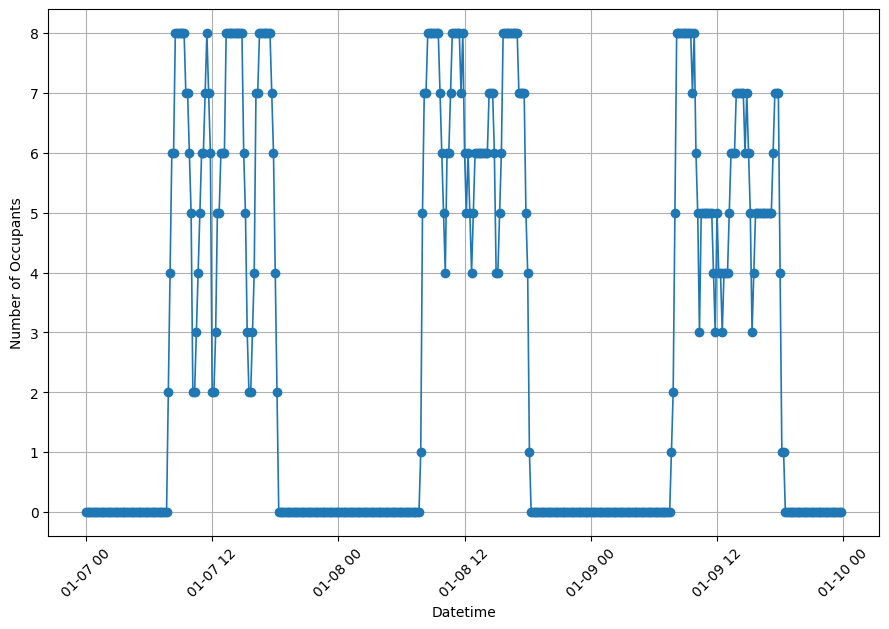

In [ ]:
import matplotlib.pyplot as plt

df_total["Date"] = pd.to_datetime(df_total["Date"])

# pick a period
week_mask = (df_total["Date"] >= "2025-01-07") & (df_total["Date"] <= "2025-01-09")
df_week = df_total[week_mask].copy()

# create a datetime index for plotting
df_week["Datetime"] = pd.to_datetime(df_week["Date"].astype(str) + " " + df_week["Time"])

# plot
plt.figure(figsize=(9, 6))
plt.plot(df_week["Datetime"], df_week["Total_Occupants"]*num_ppl, marker='o', linewidth=1.2)
plt.xlabel("Datetime")
plt.ylabel("Number of Occupants")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()